In [ ]:
# Use Python 3.10 and this transformers==4.40.1 for stable compatibility
! pip install transformers==4.40.1

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM

In [2]:
# load model and dataset
model = AutoModelForCausalLM.from_pretrained('thuml/sundial-base-128m', trust_remote_code=True)
df = pd.read_csv("https://raw.githubusercontent.com/WenWeiTHU/TimeSeriesDatasets/refs/heads/main/ETT-small/ETTh2.csv")

/Users/yong/miniconda3/envs/py310/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/yong/miniconda3/envs/py310/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# perpare input

lookback_length = 1024 
lookback = torch.tensor(df["OT"][:lookback_length]).unsqueeze(0).float()

In [4]:
# forecasting configurations

forecast_length = 288      # forecast the next 288 timestamps
num_samples = 20           # generate 20 samples
forecast = model.generate(lookback, max_new_tokens=forecast_length, num_samples=num_samples) # generate 20 probable predictions

In [5]:
print(forecast.shape)

torch.Size([1, 20, 288])


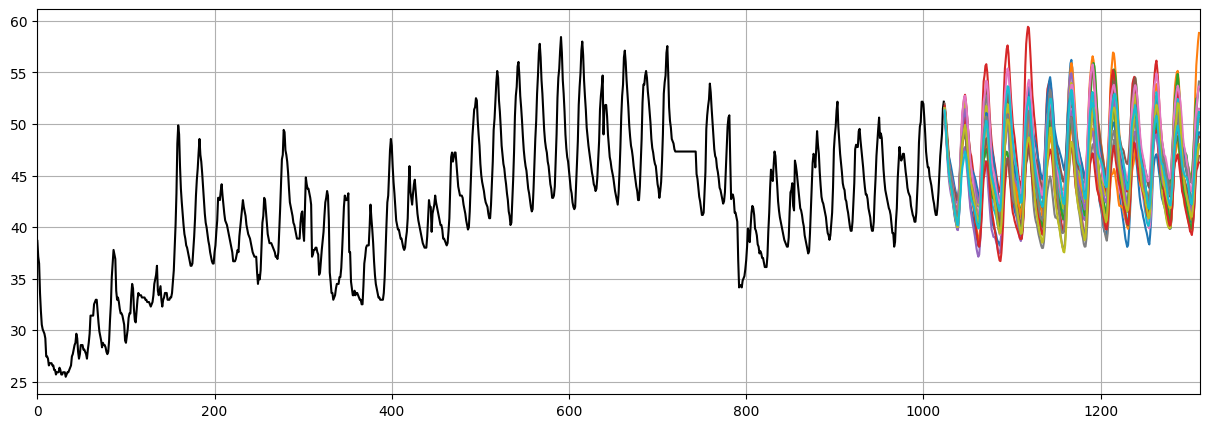

In [6]:
# visualize raw predictions
plt.figure(figsize=(15, 5))
plt.xlim(0, lookback_length + forecast_length)
plt.plot(np.arange(lookback_length), lookback[0], color='black')
plt.plot(np.arange(lookback_length, lookback_length + forecast_length), forecast[0].transpose(1, 0))
plt.grid()
plt.show()

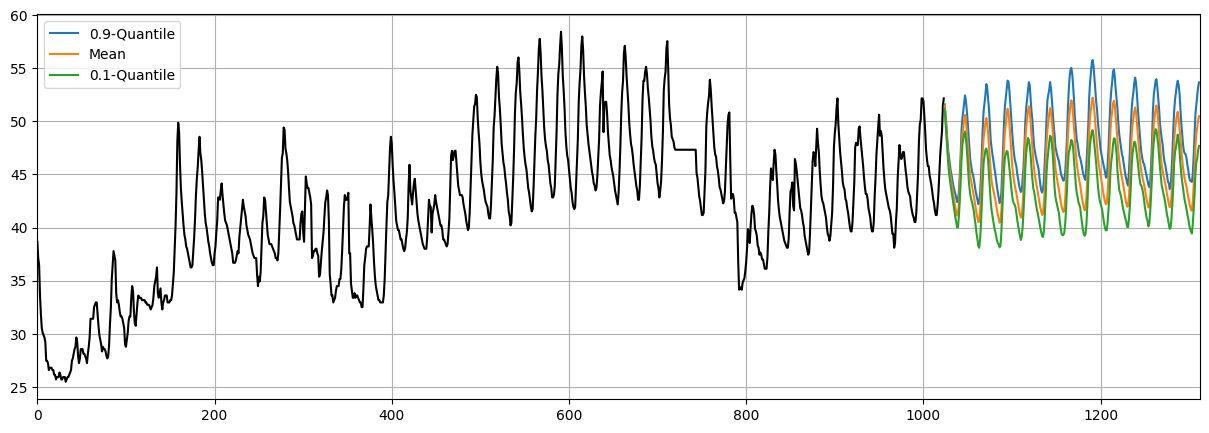

In [7]:
# visualize statistics of the predictions (mean, 0.1-quantile, 0.9-quantile)

plt.figure(figsize=(15, 5))
plt.xlim(0, lookback_length + forecast_length)
plt.plot(np.arange(lookback_length), lookback[0], color='black')
plt.plot(np.arange(lookback_length, lookback_length + forecast_length), forecast[0].quantile(q=0.9, dim=0), label='0.9-Quantile')
plt.plot(np.arange(lookback_length, lookback_length + forecast_length), forecast[0].mean(dim=0), label='Mean')
plt.plot(np.arange(lookback_length, lookback_length + forecast_length), forecast[0].quantile(q=0.1, dim=0), label='0.1-Quantile')
plt.legend()
plt.grid()
plt.show()

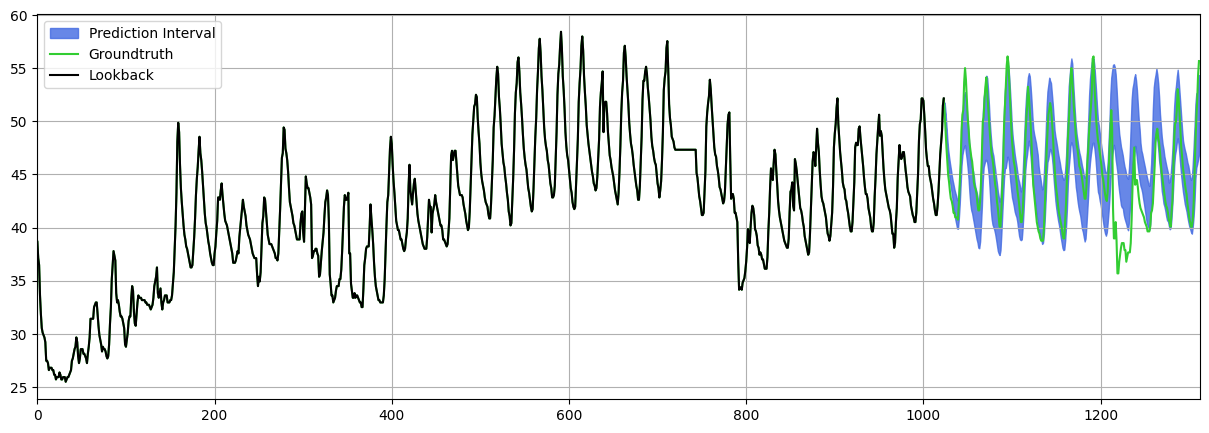

In [8]:
# plot the confidence interval of the predictions

plt.figure(figsize=(15, 5))
plt.xlim(0, lookback_length + forecast_length)
plt.fill_between(np.arange(lookback_length, lookback_length + forecast_length), forecast[0].quantile(q=0.05, dim=0), forecast[0].quantile(q=0.95, dim=0), alpha=0.8, color="royalblue", label='Prediction Interval')
plt.plot(df["OT"][:lookback_length + forecast_length], color="limegreen", label="Groundtruth")
plt.plot(df["OT"][:lookback_length], color="black", label="Lookback")
plt.legend()
plt.grid()
plt.show()
